In [1]:
from pathlib import Path
import pickle
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
import warnings
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, make_scorer
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import catboost as catb
pd.set_option('display.float_format', '{:.2f}'.format)

# FUNCTIONS 

In [3]:
def n_value_control(data_f, col_name: str, group_list: list = [], func=1):
    """
    Обработка выбросов и NaN заначений
    :param df: DataFrame
    :param col_name: название столбца
    :param cor_method: способ обработки (1 - медиана, 2 - мода, 3 - среднее)
    :return: DataFrame group by condition 
    """
    if func == 1:
        ddf = data_f.groupby(group_list)[col_name].median()
    if func == 2:
        ddf = data_f.groupby(group_list)[col_name].agg(lambda x: mode(x)[0])
    if func == 3:
        ddf = data_f.groupby(group_list)[col_name].mean()
    ddf = pd.DataFrame(ddf)
    ddf.rename(columns={col_name: 'cor_col'}, inplace=True)
    return ddf

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))


def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
    f1_macro = f1_score(y_test_pred, y_test, average='macro')
    print("f1_macro = ", f1_macro)

    return f1_macro

In [5]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels, focus):
    preds_with_true_labels = np.array(
        list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.8, 8):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(
            map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(
            map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(
            map(int, y_predicted_probs > threshold)), average='macro'))

    scores_table = pd.DataFrame({'f1': f1_scores,
                                 'precision': precisions,
                                 'recall': recalls,
                                 'probability': thresholds}).sort_values('f1', ascending=False).round(3)

    thresholds2 = []
    precisions2 = []
    recalls2 = []
    f1_scores2 = []

    for threshold2 in np.linspace(focus-0.025, focus+0.025, 15):
        thresholds2.append(threshold2)
        precisions2.append(precision_score(y_true_labels, list(
            map(int, y_predicted_probs > threshold2))))
        recalls2.append(recall_score(y_true_labels, list(
            map(int, y_predicted_probs > threshold2))))
        f1_scores2.append(f1_score(y_true_labels, list(
            map(int, y_predicted_probs > threshold2)), average='macro'))

    scores_table2 = pd.DataFrame({'f1': f1_scores2,
                                  'precision': precisions2,
                                  'recall': recalls2,
                                  'probability': thresholds2}).sort_values('f1', ascending=False).round(3)
    maxf1_proba = scores_table2.iloc[0, 3]

    figure = plt.figure(figsize=(15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.plot((maxf1_proba, maxf1_proba), (0, 1), 'g--')
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))
    plt1.table(cellText=scores_table.values,
               colLabels=scores_table.columns,
               colLoc='center', cellLoc='center', loc='bottom', bbox=[0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0],
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0],
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))
    plt2.table(cellText=scores_table2.values,
               colLabels=scores_table2.columns,
               colLoc='center', cellLoc='center', loc='bottom', bbox=[0, -1.3, 1, 1])

    plt.show()
    return maxf1_proba

In [6]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    f1 = make_scorer(f1_score, average='macro')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y,
                                                            cv=cv,
                                                            scoring=f1,
                                                            train_sizes=train_sizes,
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15, 8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [7]:
def catrgories_analysis(column_list: list):

    fig = plt.figure(facecolor='whitesmoke', figsize=(10, len(column_list)*6))
    total_axes = len(column_list)
    subplt = 1
    for x in column_list:
        ax = fig.add_subplot(total_axes, 1, subplt)
        sns.countplot(x=x, data=df_train, hue='Credit Default', palette=['navy', 'darkred'],
                      orient='v')
        plt.ylabel('Lines number', fontsize=12)
        plt.xlabel('', fontsize=12,)
        plt.xticks(rotation=90)
        plt.title(x+' groups', fontsize=16, weight='bold')
        subplt += 1
    plt.legend(title='Credit Default', loc='best')
    fig.subplots_adjust(hspace=0.1)
    plt.tight_layout()
    plt.show()

In [8]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame(
        {'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values(
        'importance', ascending=False)

    plt.figure(figsize=(10, len(feature_importances) * 0.3))

    sns.barplot(feature_importances['importance'],
                feature_importances['feature'])

    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [9]:
def train_test_num_analysis(train_df, test_df, column_list):

    fig = plt.figure(facecolor='whitesmoke', figsize=(9, len(column_list)*3))

    total_axes = len(column_list)
    subplt = 1
    for col in column_list:
        ax = fig.add_subplot(total_axes, 2, subplt)
        u, prob = mannwhitneyu(train_df[col], test_df[col])
        prob = round(prob, 3)
#             sns.set_style("whitegrid", {"axes.facecolor": ".9"})
        sns.kdeplot(train_df[col], shade=True, label='train', color='darkblue')
        sns.kdeplot(test_df[col], shade=True, label='test', color='darkred')
        plt.ylabel('Density', fontsize=12)
        plt.xlabel(col, fontsize=14,)
        plt.xticks(rotation=90)
        plt.title('Mann-Whitney p-value = '+str(prob),
                  fontsize=14, weight='bold')
        subplt += 1
        plt.legend(loc='best')
        fig.subplots_adjust(hspace=0.1)
    plt.tight_layout()
    plt.show()

In [10]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(
        100 * (start_mem - end_mem) / start_mem))

    return df

In [11]:
def cat_union_check(df, cat_list: list, target_column, p_value: float):
    df['Id'] = df.index
    column_list = []
    merge_list = []
    p_list = []
    for column in cat_list:
        table = df_train.pivot_table(
            values='Id', index=column, columns=target_column, aggfunc='count')
        table.fillna(0, inplace=True)
        table['sum'] = table.sum(axis=1)
        table['ratio'] = table[0]+table[1]
        table = table[table['sum'] > 20]
        table = table.sort_values(by='ratio', ascending=False)
        table.drop(columns=['sum', 'ratio'], inplace=True)

        while len(table) > 1:
            list_cat_merge = []
            table1 = table.drop(table.index[1:])
            table2 = table.drop(table.index[0])
            for i in range(len(table2)):
                table1 = pd.concat([table1, table2.iloc[[i]]])
                chi2, p, _, _ = chi2_contingency(table1)
                if p < p_value:
                    table1.drop(table1.tail(1).index, inplace=True)
            table = table[~table.index.isin(table1.index)]
            list_cat_merge = table1.index.tolist()
            if len(list_cat_merge) > 1:
                column_list.append(column)
                merge_list.append(list_cat_merge)
                chi2, p, _, _ = chi2_contingency(table1)
                p_list.append(p)

    df.drop(columns='Id', inplace=True)
    merge_dict = {'Column name': column_list,
                  'categories to union': merge_list, 'p-value': p_list}
    cat_merge_df = pd.DataFrame(data=merge_dict)
    pd.set_option('max_colwidth', 120)
    pd.set_option('display.width', 500)
    return cat_merge_df

In [12]:
def train_test_cat_compare(train_df, test_df, cat_list):
    dif_train_list = []
    dif_train_count = []
    colname_train_list = []
    dif_test_list = []
    dif_test_count = []
    colname_test_list = []
    for i in cat_list:
        train_cat_el = set(train_df[i].unique().tolist())
        test_cat_el = set(test_df[i].unique().tolist())
        dif_cat_train = test_cat_el - train_cat_el
        dif_cat_test = train_cat_el - test_cat_el
        if dif_cat_train != {}:
            for el in dif_cat_train:
                colname_train_list.append(i)
                dif_train_list.append(el)
                dif_train_count.append(test_df[test_df[i] == el][i].count())
        if dif_cat_test != {}:
            for el in dif_cat_test:
                colname_test_list.append(i)
                dif_test_list.append(el)
                dif_test_count.append(train_df[train_df[i] == el][i].count())

    dif_dict_test = {'Column_name': colname_train_list,
                     'Test_dif_category': dif_train_list, 'Line sum': dif_train_count}
    dif_dict_train = {'Column_name': colname_test_list,
                      'Test_dif_category': dif_test_list, 'Line sum': dif_test_count}

    if colname_train_list != []:
        print('\nКатегории присутвующие в test, но отсутсвующие в train ')
        dif_cat_test = pd.DataFrame(data=dif_dict_test)
        display(dif_cat_test)
        print('\n')

    if colname_test_list != []:
        print('\nКатегории присутвующие в train, но отсутсвующие в test ')
        dif_cat_train = pd.DataFrame(data=dif_dict_train)
        display(dif_cat_train)

    if (colname_test_list != []) & (colname_train_list != []):
        print('NO difference in train and test list of unique categorical elements')

# Load data, memory control

In [13]:
df_train = reduce_mem_usage(pd.read_csv('train.csv'))
df_test = reduce_mem_usage(pd.read_csv('test.csv'))


cat_list = df_train.select_dtypes(include='category').columns.tolist()
num_list = df_train.select_dtypes(exclude='category').columns.tolist()
num_list.remove('Credit Default')
num_cat_list = []
for el in num_list:
    if df_train[el].nunique() < 20:
        num_cat_list.append(el)
num_to_compare = list(set(num_list)-set(num_cat_list))

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%
Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.13 MB
Decreased by 58.9%


In [14]:
# сравнение категориальных данных на train и test
train_test_cat_compare(df_train, df_test, cat_list)


Категории присутвующие в train, но отсутсвующие в test 


,Column_name,Test_dif_category,Line sum
0,Purpose,renewable energy,2


In [15]:
# для уменьшения веротяности ошибок при обучении и создании модели
df_train.drop(df_train[df_train['Monthly Debt'] == 0].index,
              inplace=True)
df_train.drop(df_train[df_train['Purpose'] == 'renewable energy'].index,  # по результатам сравнения
              inplace=True)
df_train['Years in current job'].replace(
    {'< 1 year': 'less 1 year'}, inplace=True)
df_test['Years in current job'].replace(
    {'< 1 year': 'less 1 year'}, inplace=True)
df_train['Years in current job'] = df_train['Years in current job'].astype(
    'category')
df_test['Years in current job'] = df_train['Years in current job'].astype(
    'category')

train_idx = np.arange(0, len(df_train), 1)
df_train.set_index(train_idx, inplace=True)
test_idx = np.arange(len(df_train), len(df_train)+len(df_test), 1)
df_test.set_index(test_idx, inplace=True)

# EDA

In [16]:
display(df_train.describe(percentiles=[.5]), df_test.describe(
    percentiles=[.5, ]), df_train.info(), df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7492 entries, 0 to 7491
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7492 non-null   category
 1   Annual Income                 5940 non-null   float32 
 2   Years in current job          7121 non-null   category
 3   Tax Liens                     7492 non-null   float32 
 4   Number of Open Accounts       7492 non-null   float32 
 5   Years of Credit History       7492 non-null   float32 
 6   Maximum Open Credit           7492 non-null   float32 
 7   Number of Credit Problems     7492 non-null   float32 
 8   Months since last delinquent  3414 non-null   float32 
 9   Bankruptcies                  7479 non-null   float32 
 10  Purpose                       7492 non-null   category
 11  Term                          7492 non-null   category
 12  Current Loan Amount           7492 non-null   fl

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5940.00,7492.00,7492.00,7492.00,7492.00,7492.00,3414.00,7479.00,7492.00,7492.00,7492.00,5940.00,7492.00
mean,1366683.38,0.03,11.14,18.32,946098.19,0.17,34.68,0.12,11872323.00,290109.56,18331.84,1151.30,0.28
std,845399.12,0.27,4.91,7.04,16034695.00,0.50,21.68,0.35,31924904.00,317921.00,11920.66,1604.83,0.45
min,164597.00,0.00,2.00,4.00,0.00,0.00,0.00,0.00,11242.00,0.00,17.00,585.00,0.00
50%,1168424.00,0.00,10.00,17.00,479116.00,0.00,32.00,0.00,309650.00,209551.00,16087.00,731.00,0.00
max,10149344.00,7.00,43.00,57.70,1304726144.00,7.00,118.00,4.00,100000000.00,6506797.00,136679.00,7510.00,1.00


,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1987.00,2500.00,2500.00,2500.00,2500.00,2500.00,1142.00,2497.00,2500.00,2500.00,2500.00,1987.00
mean,1366920.75,0.04,11.18,18.33,710570.12,0.16,34.18,0.11,12155693.00,296396.53,18271.30,1234.52
std,917124.50,0.39,4.85,7.25,1511982.88,0.56,22.02,0.36,32261024.00,378302.06,11543.88,1740.22
min,106533.00,0.00,1.00,3.90,0.00,0.00,0.00,0.00,15422.00,0.00,93.00,585.00
50%,1178475.00,0.00,10.00,17.00,478676.00,0.00,30.00,0.00,322366.00,207385.00,16642.50,731.00
max,14975610.00,15.00,48.00,53.40,54484384.00,15.00,82.00,5.00,100000000.00,6030087.00,93555.00,7480.00


None

None

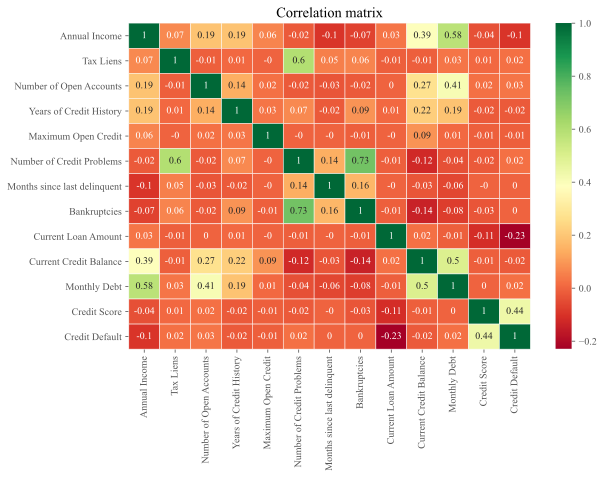

In [17]:
plt.figure(figsize=(9, 6))
corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='RdYlGn')
plt.title('Correlation matrix')
plt.show()

In [18]:
job_df = n_value_control(df_train, 'Annual Income', [
                         'Years in current job'], 3)

display(job_df, df_train['Annual Income']
        [df_train['Years in current job'].isna()].median())

,cor_col
Years in current job,
1 year,1271418.75
10+ years,1511082.12
2 years,1324516.62
3 years,1396487.25
4 years,1371733.50
5 years,1330785.62
6 years,1311730.12
7 years,1341805.00
8 years,1390800.25


862970.5

# Handling outliers. Data preprocessing

1. Пропущенное значение категорий в  колонке 'Years in current job' имеет средний доход ниже, чем в остальных категориях. Поэтому присвоим пропускам значение 'unemployed'
2. Незаполнененные значения колонки 'Annual Income' с учетом матрицы корреляций (с большой зависимостью от 'Monthly Debt') заполним с помощью модели регрессии
3. С учетом зависимости кредитного рейтинга от кредитной истории, долговой нагрузки, дохода, просрочек и других параметров, присутсвующих в датасете, колонку "Credit Score" так же заполним с помощью модели регрессии
4. Остальные пропуски и выбросы - по кроссвалидации

In [19]:
class PipelinePreparation:

    def __init__(self):

        self.annual_income_control = None
        self.years_job_control = None
        self.loan_amount_control = None
        self.credit_history_control = None
        self.credit_score_control = None
        self.max_credit_control = None
        self.number_accounts_control = None
        self.credit_balance_control = None
        self.ind_trn = None
        self.ind_tst = None
        self.medians = None

       #################################################################################
    def df_outliers(self, X):  # определение выбросов

        X['Month since last delinquent Nan'] = 0
        X.loc[X['Months since last delinquent'].isna(
        ), 'Month since last delinquent Nan'] = 1

        X['No Income_Score Data'] = 0
        X.loc[X['Annual Income'].isna(), 'No Income_Score Data'] = 1
        X.loc[X['Annual Income'] > X['Annual Income'].quantile(
            q=0.99), 'Annual Income'] = np.nan
        
        X.loc[X['Number of Open Accounts'] > X['Number of Open Accounts'].quantile(
            q=0.99), 'Number of Open Accounts'] = np.nan

        X.loc[X['Current Credit Balance'] > X['Current Credit Balance'].quantile(
            q=0.98), 'Current Credit Balance'] = np.nan

        X['CS_outlier'] = 0
        X.loc[X['Credit Score'] > 850, 'CS_outlier'] = 1
        X.loc[X['Credit Score'] > 850, 'Credit Score'] = X['Credit Score']/10

        X['Maximum Open Credit Outlier'] = 0
        X.loc[X['Maximum Open Credit'] > X['Maximum Open Credit'].quantile(
            q=0.99), 'Maximum Open Credit Outlier'] = 1
        X.loc[X['Maximum Open Credit'] > X['Maximum Open Credit'].quantile(
            q=0.99), 'Maximum Open Credit'] = np.nan

        X['Loan Amount Outlier'] = 0
        X.loc[X['Current Loan Amount'] > 805869, 'Loan Amount Outlier'] = 1
        X.loc[X['Current Loan Amount'] > 805869,
              'Current Loan Amount'] = np.nan

        return X

       #################################################################################

    def fill_values_pre(self, X):  # определение значений для заполнения пропусков/выбросов

        self.medians = X.median()
       
        self.years_job_control = X['Years in current job'].unique()[11]
        self.annual_income_control = X['Annual Income'].median()
        self.credit_balance_control = X['Current Credit Balance'].median()

        self.loan_amount_control = n_value_control(
            X, 'Current Loan Amount', ['Purpose', 'Term'], 3)
        self.loan_amount_control[self.loan_amount_control.isna(
        )] = X['Current Loan Amount'].median()

        self.credit_score_control = round(X['Credit Score'].median())
        self.max_credit_control = X['Maximum Open Credit'].median()
        self.number_accounts_control = X['Number of Open Accounts'].median()

        #################################################################################

    def gap_filling(self, X):  # функция заполнения

        if 'LA_cut' not in X.columns:
            bins = np.linspace(10000, 800000, 150)
            X['LA_cut'] = pd.cut(X['Current Loan Amount'],
                                 bins=bins, labels=False)

        X['Months since last delinquent'].fillna(0, inplace=True)
        X['Bankruptcies'].fillna(0, inplace=True)
        X['Years in current job'] = X['Years in current job'].astype('object')
        X['Years in current job'].fillna('unemployed', inplace=True)
        X['Years in current job'] = X['Years in current job'].astype(
            'category')
        X['Maximum Open Credit'].fillna(self.max_credit_control, inplace=True)
        X['Number of Open Accounts'].fillna(
            self.number_accounts_control, inplace=True)
        X['Current Credit Balance'].fillna(
            self.credit_balance_control, inplace=True)

        X = pd.merge(X, self.loan_amount_control['cor_col'],  how='left', left_on=['Purpose', 'Term'],
                     right_on=['Purpose', 'Term'])
        X.loc[X['Current Loan Amount'].isna(), 'Current Loan Amount'] = X['cor_col']
        X.drop('cor_col', axis='columns', inplace=True)

        return X

      #################################################################################

    @staticmethod
    # предсказание "Annual Income"
    def predict_income(train_df, test_df, col_to_pre, xgb_params):

        full_table = pd.concat([train_df,  test_df])
        dftrain_to_pre = full_table.loc[~full_table[col_to_pre].isna()]
        dftest_to_pre = full_table.loc[full_table[col_to_pre].isna()]
        train_df = dftrain_to_pre.copy()
        test_df = dftest_to_pre.copy()

        dftrain_to_pre.drop(
            columns=['Credit Score', 'Credit Default'], inplace=True)
        dftest_to_pre.drop(
            columns=['Credit Score', 'Credit Default'], inplace=True)
#         savename_1 = "./tunning/tunning" + str(col_to_pre)[:5]+".csv"
#         dftrain_to_pre.to_csv(savename_1)

        # target encoding
        med_income_house = n_value_control(dftrain_to_pre, 'Annual Income', ['Home Ownership']).rename(
            columns={'cor_col': 'MedInHouse'})
        med_income_house_job = n_value_control(dftrain_to_pre, 'Annual Income', ['Home Ownership', 'Years in current job']).rename(
            columns={'cor_col': 'MedInHouseJob'})
        med_income_job = n_value_control(dftrain_to_pre, 'Annual Income', ['Years in current job']).rename(
            columns={'cor_col': 'MedInJob'})
        med_income_acc = n_value_control(dftrain_to_pre, 'Annual Income', ['Number of Open Accounts']).rename(
            columns={'cor_col': 'MedInAcc'})
        med_income_pur = n_value_control(dftrain_to_pre, 'Annual Income', ['Purpose']).rename(
            columns={'cor_col': 'MedInpur'})

        dftrain_to_pre = pd.merge(dftrain_to_pre, med_income_house['MedInHouse'],  how='left', left_on=[
            'Home Ownership'], right_on=['Home Ownership'])
        dftrain_to_pre['MedInHouse'].fillna(
            med_income_house['MedInHouse'].median(), inplace=True)

        dftrain_to_pre = pd.merge(dftrain_to_pre, med_income_house_job['MedInHouseJob'],  how='left', left_on=[
            'Home Ownership', 'Years in current job'], right_on=['Home Ownership', 'Years in current job'])
        dftrain_to_pre['MedInHouseJob'].fillna(
            med_income_house_job['MedInHouseJob'].median(), inplace=True)

        dftrain_to_pre = pd.merge(dftrain_to_pre, med_income_job['MedInJob'],  how='left', left_on=[
            'Years in current job'], right_on=['Years in current job'])
        dftrain_to_pre['MedInJob'].fillna(
            med_income_job['MedInJob'].median(), inplace=True)

        dftrain_to_pre = pd.merge(dftrain_to_pre, med_income_acc['MedInAcc'],  how='left', left_on=[
            'Number of Open Accounts'], right_on=['Number of Open Accounts'])
        dftrain_to_pre['MedInAcc'].fillna(
            med_income_acc['MedInAcc'].median(), inplace=True)

        dftrain_to_pre = pd.merge(dftrain_to_pre, med_income_pur['MedInpur'],  how='left', left_on=[
            'Purpose'], right_on=['Purpose'])
        dftrain_to_pre['MedInpur'].fillna(
            med_income_pur['MedInpur'].median(), inplace=True)

        dftest_to_pre = pd.merge(dftest_to_pre, med_income_house['MedInHouse'],  how='left', left_on=[
            'Home Ownership'], right_on=['Home Ownership'])

        dftest_to_pre['MedInHouse'].fillna(
            med_income_house['MedInHouse'].median(), inplace=True)

        dftest_to_pre = pd.merge(dftest_to_pre, med_income_house_job['MedInHouseJob'],  how='left', left_on=[
            'Home Ownership', 'Years in current job'], right_on=['Home Ownership', 'Years in current job'])
        dftest_to_pre['MedInHouseJob'].fillna(
            med_income_house_job['MedInHouseJob'].median(), inplace=True)

        dftest_to_pre = pd.merge(dftest_to_pre, med_income_job['MedInJob'],  how='left', left_on=[
            'Years in current job'], right_on=['Years in current job'])
        dftest_to_pre['MedInJob'].fillna(
            med_income_job['MedInJob'].median(), inplace=True)

        dftest_to_pre = pd.merge(dftest_to_pre, med_income_acc['MedInAcc'],  how='left', left_on=[
            'Number of Open Accounts'], right_on=['Number of Open Accounts'])
        dftest_to_pre['MedInAcc'].fillna(
            med_income_acc['MedInAcc'].median(), inplace=True)

        dftest_to_pre = pd.merge(dftest_to_pre, med_income_pur['MedInpur'],  how='left', left_on=[
            'Purpose'], right_on=['Purpose'])
        dftest_to_pre['MedInpur'].fillna(
            med_income_pur['MedInpur'].median(), inplace=True)

        dftrain_to_pre = pd.get_dummies(dftrain_to_pre)
        dftest_to_pre = pd.get_dummies(dftest_to_pre)

        features = ['Monthly Debt',
                    'MedInHouseJob',
                    'Current Loan Amount',
                    'Loan Amount Outlier',
                    'MedInHouse',
                    'Purpose_debt consolidation',
                    'Maximum Open Credit',
                    'MedInpur',
                    'Years of Credit History',
                    'Term_Long Term',
                    'Maximum Open Credit Outlier',
                    'Years in current job_1 year',
                    'Months since last delinquent',
                    'Current Credit Balance',
                    'MedInJob',
                    'Number of Credit Problems',
                    'Number of Open Accounts',
                    'Purpose_wedding',
                    'Years in current job_3 years',
                    'Purpose_business loan',
                    'Years in current job_unemployed',
                    'MedInAcc',
                    'Years in current job_2 years',
                    'Tax Liens',
                    'Bankruptcies',
                    'Home Ownership_Rent',
                    'Years in current job_10+ years',
                    'Home Ownership_Have Mortgage',
                    'No Income_Score Data',
                    'Purpose_vacation']

        model_xgb = xgb.XGBRegressor(**xgb_params)
        model_xgb.fit(dftrain_to_pre[features],
                      dftrain_to_pre['Annual Income'])

        cv_score = cross_val_score(model_xgb, dftrain_to_pre[features], dftrain_to_pre['Annual Income'], scoring='r2', cv=KFold(
            n_splits=5, shuffle=True, random_state=13))
        print('R2 mean = ', round(cv_score.mean(), 3))

        predictions = model_xgb.predict(dftest_to_pre[features]).round()
        test_df['Annual Income'] = predictions
        full_table = pd.concat([train_df,  test_df])
        cat_list = full_table.select_dtypes(include='object').columns.tolist()
        full_table[cat_list] = full_table[cat_list].astype('category')
        test_df_pre = full_table.drop(train_idx)
        train_df_pre = full_table.drop(test_idx)

        del full_table, dftest_to_pre, dftrain_to_pre, train_df, test_df
        savename_model = "./models/pre_income.pkl"
        with open(savename_model, 'wb') as file:
            pickle.dump(model_xgb, file)

        return train_df_pre, test_df_pre

        ################################################################################################

    @staticmethod
    # предсказание "Credit Score"
    def predict_creditscore(train_df, test_df, col_to_pre, xgb_params):

        ind_trn = train_df.shape[0]
        ind_tst = test_df.shape[0]

        full_table = pd.concat([train_df,  test_df])

        dftrain_to_pre = full_table.loc[~full_table[col_to_pre].isna()]
        dftest_to_pre = full_table.loc[full_table[col_to_pre].isna()]

        train_df = dftrain_to_pre.copy()
        test_df = dftest_to_pre.copy()

        dftrain_to_pre.drop(columns=['Credit Default'], inplace=True)
        dftest_to_pre.drop(columns=['Credit Default'], inplace=True)
#         savename_1 = "./tunning/tunning" + str(col_to_pre)[:5]+".csv"
#         dftrain_to_pre.to_csv(savename_1)

        Med_sc_house_job = n_value_control(dftrain_to_pre, 'Credit Score', ['Home Ownership', 'Years in current job'], 3).rename(
            columns={'cor_col': 'MedScHouseJob'})
        Med_sc_acc = n_value_control(dftrain_to_pre, 'Credit Score', ['Number of Open Accounts']).rename(
            columns={'cor_col': 'MedScAcc'})
        Med_sc_pur = n_value_control(dftrain_to_pre, 'Credit Score', ['Purpose']).rename(
            columns={'cor_col': 'MedScpur'})
        Med_sc_term = n_value_control(dftrain_to_pre, 'Credit Score', ['Term']).rename(
            columns={'cor_col': 'MedScterm'})

        bins = np.linspace(10000, 800000, 100)
        dftrain_to_pre['Sc_cut'] = pd.cut(
            dftrain_to_pre['Current Loan Amount'], bins=bins, labels=False)
        dftest_to_pre['Sc_cut'] = pd.cut(
            dftest_to_pre['Current Loan Amount'], bins=bins, labels=False)

        Med_sc_la = n_value_control(dftrain_to_pre, 'Credit Score', ['Sc_cut']).rename(
            columns={'cor_col': 'MedScScla'})

        dftrain_to_pre = pd.merge(dftrain_to_pre, Med_sc_house_job['MedScHouseJob'],  how='left', left_on=[
            'Home Ownership', 'Years in current job'], right_on=['Home Ownership', 'Years in current job'])
        dftrain_to_pre['MedScHouseJob'].fillna(
            Med_sc_house_job['MedScHouseJob'].median(), inplace=True)

        dftrain_to_pre = pd.merge(dftrain_to_pre, Med_sc_acc['MedScAcc'],  how='left', left_on=[
            'Number of Open Accounts'], right_on=['Number of Open Accounts'])
        dftrain_to_pre['MedScAcc'].fillna(
            Med_sc_acc['MedScAcc'].median(), inplace=True)

        dftrain_to_pre = pd.merge(dftrain_to_pre, Med_sc_pur['MedScpur'],  how='left', left_on=[
            'Purpose'], right_on=['Purpose'])
        dftrain_to_pre['MedScpur'].fillna(
            Med_sc_pur['MedScpur'].median(), inplace=True)

        dftrain_to_pre = pd.merge(dftrain_to_pre, Med_sc_term['MedScterm'],  how='left', left_on=[
            'Term'], right_on=['Term'])

        dftrain_to_pre = pd.merge(dftrain_to_pre, Med_sc_la['MedScScla'],  how='left', left_on=[
            'Sc_cut'], right_on=['Sc_cut'])

        dftest_to_pre = pd.merge(dftest_to_pre, Med_sc_house_job['MedScHouseJob'],  how='left', left_on=[
            'Home Ownership', 'Years in current job'], right_on=['Home Ownership', 'Years in current job'])
        dftest_to_pre['MedScHouseJob'].fillna(
            Med_sc_house_job['MedScHouseJob'].median(), inplace=True)

        dftest_to_pre = pd.merge(dftest_to_pre, Med_sc_acc['MedScAcc'],  how='left', left_on=[
            'Number of Open Accounts'], right_on=['Number of Open Accounts'])
        dftest_to_pre['MedScAcc'].fillna(
            Med_sc_acc['MedScAcc'].median(), inplace=True)

        dftest_to_pre = pd.merge(dftest_to_pre, Med_sc_pur['MedScpur'],  how='left', left_on=[
            'Purpose'], right_on=['Purpose'])
        dftest_to_pre['MedScpur'].fillna(
            Med_sc_pur['MedScpur'].median(), inplace=True)

        dftest_to_pre = pd.merge(dftest_to_pre, Med_sc_term['MedScterm'],  how='left', left_on=[
            'Term'], right_on=['Term'])

        dftest_to_pre = pd.merge(dftest_to_pre, Med_sc_la['MedScScla'],  how='left', left_on=[
            'Sc_cut'], right_on=['Sc_cut'])

        dftrain_to_pre = pd.get_dummies(dftrain_to_pre)
        dftest_to_pre = pd.get_dummies(dftest_to_pre)

        features = ['MedScterm',
                    'Loan Amount Outlier',
                    'MedScpur',
                    'MedScScla',
                    'Maximum Open Credit',
                    'Purpose_business loan',
                    'Purpose_educational expenses',
                    'Purpose_small business',
                    'MedScHouseJob',
                    'MedScAcc',
                    'Number of Credit Problems',
                    'Current Credit Balance',
                    'Months since last delinquent',
                    'Bankruptcies',
                    'Purpose_debt consolidation',
                    'Years of Credit History',
                    'Home Ownership_Home Mortgage',
                    'Monthly Debt',
                    'Number of Open Accounts',
                    'Current Loan Amount',
                    'Maximum Open Credit Outlier',
                    'Purpose_wedding',
                    'Years in current job_7 years',
                    'Annual Income',
                    'Years in current job_1 year',
                    'Purpose_medical bills',
                    'Home Ownership_Rent',
                    'Purpose_vacation',
                    'Years in current job_10+ years',
                    'Purpose_major purchase']

        model_xgb = xgb.XGBRegressor(**xgb_params)
        model_xgb.fit(dftrain_to_pre[features],
                      dftrain_to_pre['Credit Score'])

        cv_score = cross_val_score(model_xgb, dftrain_to_pre[features], dftrain_to_pre['Credit Score'], scoring='r2', cv=KFold(
            n_splits=5, shuffle=True, random_state=13))
        print('R2 mean = ', round(cv_score.mean(), 3))

        predictions = model_xgb.predict(dftest_to_pre[features]).round()
        test_df['Credit Score'] = predictions
        full_table = pd.concat([train_df,  test_df])
        cat_list = full_table.select_dtypes(include='object').columns.tolist()
        full_table[cat_list] = full_table[cat_list].astype('category')
        test_df_pre = full_table.drop(train_idx)
        train_df_pre = full_table.drop(test_idx)
        test_df_pre.drop(columns=['Credit Default'], inplace=True)

#         train_df_pre.info()
        del full_table, dftest_to_pre, dftrain_to_pre, train_df, test_df
        savename_model = "./models/pre_crscore.pkl"
        with open(savename_model, 'wb') as file:
            pickle.dump(model_xgb, file)

        return train_df_pre, test_df_pre

In [20]:
class FeaturesBalancePipeline:

    def __init__(self):

        self.Home_target = None
        self.Job_target = None
        self.Tax_target = None
        self.Accounts_target = None
        self.Problems_target = None
        self.Bankruptcies_target = None
        self.Purpose_target = None
        self.Term_target = None
        self.Creditscore_target = None
        self.LA_target = None
        self.LA_target_Purpose = None

    def fit_target(self, X):

        # средние занчения target по категориям


        self.Home_target = n_value_control(X, 'Credit Default', ['Home Ownership'], 3).rename(
            columns={'cor_col': 'Home_target'})
        self.Job_target = n_value_control(X, 'Credit Default', ['Years in current job'], 3).rename(
            columns={'cor_col': 'Job_target'})
        self.Purpose_target = n_value_control(X, 'Credit Default', ['Purpose'], 3).rename(
            columns={'cor_col': 'Purpose_target'})
        self.Term_target = n_value_control(X, 'Credit Default', ['Term'], 3).rename(
            columns={'cor_col': 'Term_target'})

    def transform(self, X):
        
        # Target encoding
        
        X = pd.merge(X, self.Home_target['Home_target'],  how='left', left_on=[
            'Home Ownership'], right_on=['Home Ownership'])
        X['Home_target'].fillna(
            self.Home_target['Home_target'].median(), inplace=True)

        X = pd.merge(X, self.Job_target['Job_target'],  how='left', left_on=[
            'Years in current job'], right_on=['Years in current job'])
        X['Job_target'].fillna(
            self.Job_target['Job_target'].median(), inplace=True)

        X = pd.merge(X, self.Purpose_target['Purpose_target'],  how='left', left_on=[
            'Purpose'], right_on=['Purpose'])
        X['Purpose_target'].fillna(
            self.Purpose_target['Purpose_target'].median(), inplace=True)

        X = pd.merge(X, self.Term_target['Term_target'],  how='left', left_on=[
            'Term'], right_on=['Term'])
        X['Term_target'].fillna(
            self.Term_target['Term_target'].median(), inplace=True)


        # New Features
        X['Sel_per_mon'] = X['Annual Income']/12
        X['Selmondept'] = X['Sel_per_mon']/X['Monthly Debt']
        X['Mon_to pay'] = X['Current Loan Amount'] / \
            X['Monthly Debt']
        X['balanse_amount'] = X['Current Credit Balance'] / \
            X['Current Loan Amount']
        X['max_current'] = X['Maximum Open Credit'] / \
            X['Current Loan Amount']
        X['maxc_income'] = X['Maximum Open Credit'] / \
            X['Annual Income']
        X['loan_income'] = X['Current Loan Amount'] / \
            X['Annual Income']
        X['balace_debt'] = X['Current Credit Balance'] / \
            X['Monthly Debt']
        X['balace_income'] = X['Current Credit Balance'] / \
            X['Annual Income']
        X['income_acc'] = X['Annual Income'] / \
            X['Number of Open Accounts']

        if 'LA_cut' in X.columns:
            X.drop('LA_cut', axis='columns', inplace=True)
        if 'Term' in X.columns:
            X.drop('Term', axis='columns', inplace=True)
        if 'Purpose' in X.columns:
            X.drop('Purpose', axis='columns', inplace=True)
        if 'Years in current job' in X.columns:
            X.drop('Years in current job', axis='columns', inplace=True)
        if 'Home Ownership' in X.columns:
            X.drop('Home Ownership', axis='columns', inplace=True)


        return X

    @staticmethod
    def split_balanced(train_df, target):

        train_df['Credit Default'] = train_df['Credit Default'].astype('int8')
        train_df = pd.get_dummies(train_df)
        target_counts = train_df[target].value_counts()
        major_class_name = target_counts.argmax()
        minor_class_name = target_counts.argmin()
        disbalance_coeff = int(
            target_counts[major_class_name] / target_counts[minor_class_name]) - 1
        X_train, X_test, y_train, y_test = train_test_split(train_df.drop(columns=target), train_df[target],
                                                            shuffle=True,
                                                            test_size=0.25,
                                                            random_state=13,
                                                            stratify=train_df[target])

        df_for_balancing = pd.concat([X_train, y_train], axis=1)
        df_for_balancing['Credit Default'] = df_for_balancing['Credit Default'].astype(
            'int8')

        for i in range(disbalance_coeff):
            sample = train_df[train_df[target] == minor_class_name].sample(
                target_counts[minor_class_name])
            train_df = train_df.append(sample, ignore_index=True)

        target_counts = df_for_balancing[target].value_counts()
        major_class_name = target_counts.argmax()
        minor_class_name = target_counts.argmin()
        disbalance_coeff = int(
            target_counts[major_class_name] / target_counts[minor_class_name]) - 1

        for i in range(disbalance_coeff):
            sample2 = df_for_balancing[df_for_balancing[target] == minor_class_name].sample(
                target_counts[minor_class_name])
            df_for_balancing = df_for_balancing.append(
                sample2, ignore_index=True)

        X_train_balanced = df_for_balancing.drop(columns=target)
        y_train_balanced = df_for_balancing[target]
        savename_1 = "./tunning/finalbal_tunning_cl.csv"
        df_train.to_csv(savename_1)
        X_balanced = train_df.drop(columns=target)
        y_balanced = train_df[target]
        print(train_df[target].value_counts())

        return X_balanced, y_balanced, X_train_balanced, y_train_balanced, X_test, y_test

In [21]:
ind_trn = df_train.shape[0]
ind_tst = df_test.shape[0]
pl_pre = PipelinePreparation()
# определение выбросов
df_train = pl_pre.df_outliers(df_train)
df_test = pl_pre.df_outliers(df_test)
pl_pre.fill_values_pre(df_train)
#заполнение пропусков
df_train = pl_pre.gap_filling(df_train)
df_test = pl_pre.gap_filling(df_test)
#подготовка датасетов к заполнению пропусков моделями
train_idx = np.arange(0, len(df_train), 1)
df_train.set_index(train_idx, inplace=True)
test_idx = np.arange(len(df_train), len(df_train)+len(df_test), 1)
df_test.set_index(test_idx, inplace=True)

In [22]:
# заполняем значения Annual Income

params = {'random_state': 13,
          'learning_rate': 0.1,
          'max_depth': 2,
          'n_estimators': 220}
df_train, df_test = pl_pre.predict_income(
    df_train, df_test, 'Annual Income', params)

R2 mean =  0.469


In [23]:
# заполняем значения Credit Score, с помощью модели Регрессии
# кроссвалидация показала лучшие результаты по сравниию с заполнением медианой

params = {'random_state': 13,
          'learning_rate': 0.05,
          'max_depth': 4,
          'n_estimators': 210}
df_train, df_test = pl_pre.predict_creditscore(
    df_train, df_test, 'Credit Score', params)

R2 mean =  0.349


# Data post-processing review

Проверим категориальные признаки на согласованность частот

In [24]:
cat_union_check(df_train, cat_list, 'Credit Default', 0.9)

,Column name,categories to union,p-value
0,Years in current job,"[10+ years, 2 years, 3 years, less 1 year, 5 years, 1 year, 4 years, 6 years, 7 years, 8 years, 9 years]",1.00
1,Purpose,"[debt consolidation, buy house]",0.99
2,Purpose,"[other, medical bills, take a trip]",0.94
3,Purpose,"[buy a car, major purchase]",0.93


**Часть категорий имеют схожее влияние на целевую переменную и могут быть объеденены с p-value близким к 1 
(с минимальной потерей данных)**

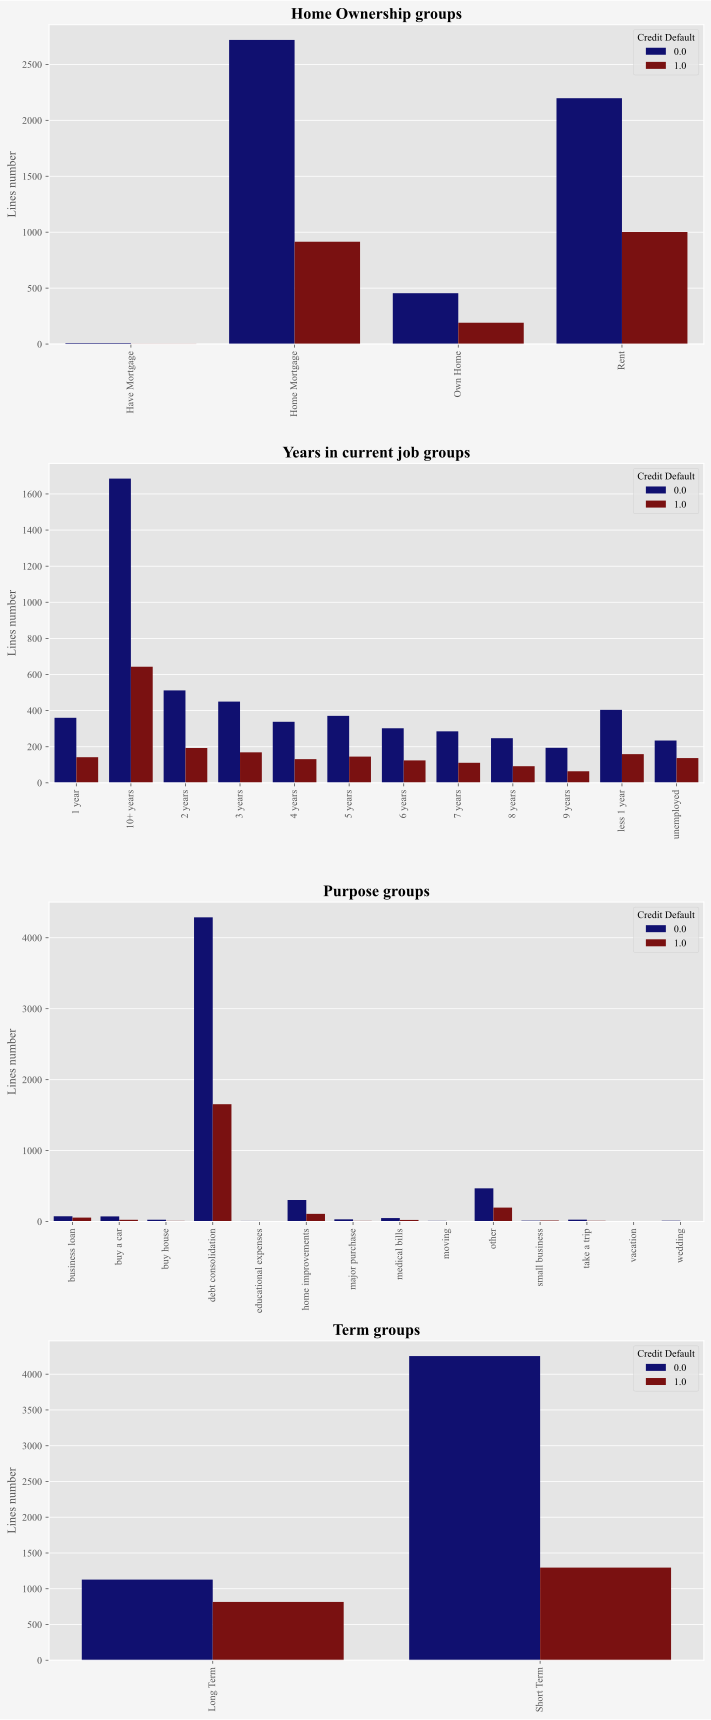

In [25]:
catrgories_analysis(cat_list)

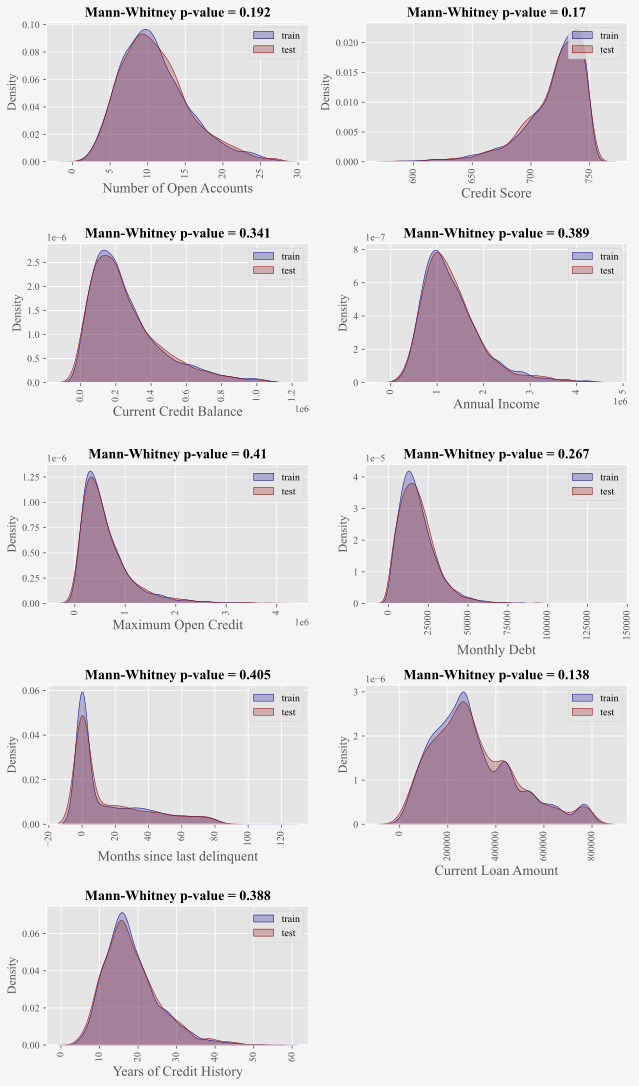

In [26]:
train_test_num_analysis(df_train, df_test, num_to_compare)

**Распределения train и test похожи.**

In [27]:
# сортировка тестового датасета в исходное состояние, после предсказания данных
df_test.sort_index(ascending=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [28]:
# генерация фичей
fit_balance = FeaturesBalancePipeline()
fit_balance.fit_target(df_train)
df_train = fit_balance.transform(df_train)
df_test = fit_balance.transform(df_test)

# Model and features selection

In [29]:
disbalance = df_train['Credit Default'].value_counts(
)[0] / df_train['Credit Default'].value_counts()[1]


In [30]:
features = [
    #     'Loan Amount Outlier',
    #     'CS_outlier',
    'Term_target',
    'Credit Score',
    'No Income_Score Data',
    #  'Current Loan Amount',
    'Selmondept',
    'loan_income',
    'Annual Income',
    'Home_target',
    'income_acc',
    #  'max_current',
    'Maximum Open Credit',
    'Job_target',
    'Purpose_target',
    'Current Credit Balance',
    'Monthly Debt',
    'balace_income',
    'Months since last delinquent',
    'maxc_income',
    #   'Mon_to pay',
    'balanse_amount',
    'Number of Open Accounts',
    'balace_debt',
    'Years of Credit History',
    'Number of Credit Problems',
#     'Tax Liens',
#     'Maximum Open Credit Outlier',
#     'Month since last delinquent Nan',
#     'Bankruptcies'
]

In [31]:
# savename_1 = "./tunning/finalbal_tunning_cl.csv"
# df_train.to_csv(savename_1)

X = df_train.drop(columns=['Credit Default'])
y = df_train['Credit Default']
X = df_train[features]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    test_size=0.25,
                                                    random_state=13,
                                                    stratify=y)

In [32]:
model_xgb = xgb.XGBClassifier(random_state=13,
                              scale_pos_weight=disbalance,
                              reg_lambda=13,
                              learning_rate=0.1,
                              max_depth=3,
                              n_estimators=120,
                              base_score=0.562
                              )
model_xgb.fit(X_train, y_train)
f1_macro_xgb = evaluate_preds(model_xgb, X_train, X_test, y_train, y_test)

[14:21:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

         0.0       0.86      0.70      0.77      4036
         1.0       0.48      0.70      0.57      1583

    accuracy                           0.70      5619
   macro avg       0.67      0.70      0.67      5619
weighted avg       0.75      0.70      0.71      5619

TEST

              precision    recall  f1-score   support

         0.0       0.81      0.67      0.73      1346
         1.0       0.41      0.59      0.49       527

    accuracy                           0.65      1873
   macro avg       0.61      0.63      0.61      1873
weighted avg       0.70      0.65      0.66      1873

CONFUSION MATRIX

col_0

# Model tuning.  Class prediction.

In [33]:
params = {
    'reg_lambda': 0.588,
    'learning_rate': 0.061,
    'max_depth': 4,
    'n_estimators': 110
}

model_xgb = xgb.XGBClassifier(**params,
                              random_state=13,
                              scale_pos_weight=disbalance,
                              importance_type='weight',
                               base_score=0.56
                              )
model_xgb.fit(X, y)


[14:21:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.56, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='weight', interaction_constraints='',
              learning_rate=0.061, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=110, n_jobs=16, num_parallel_tree=1, random_state=13,
              reg_alpha=0, reg_lambda=0.588,
              scale_pos_weight=2.5507109004739337, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

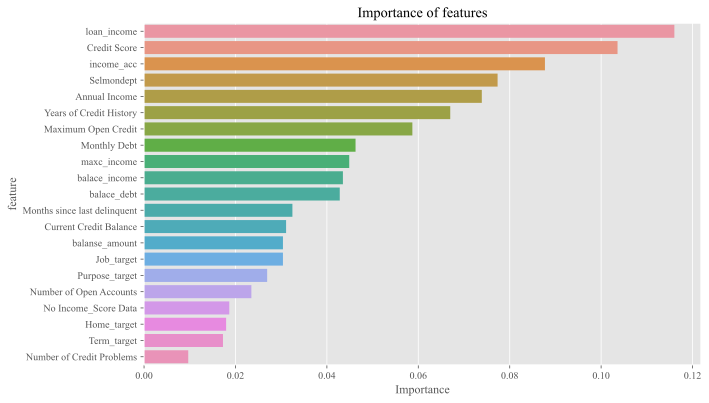

In [34]:
important_features_top = show_feature_importances(X.columns,
                                                  model_xgb.feature_importances_, get_top=60)


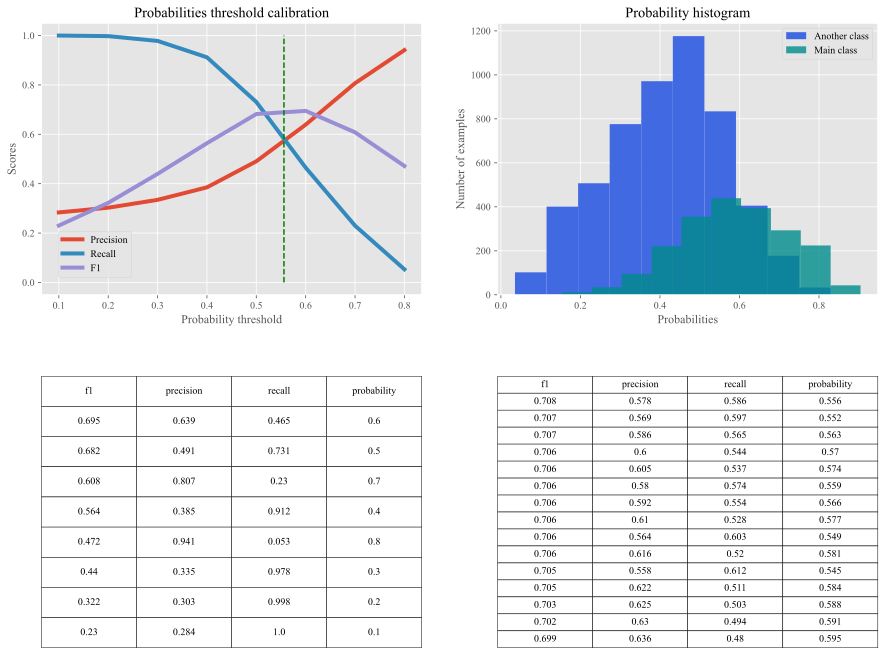

In [35]:
# пороговую вероятность внесем в параметр base_score XGBClassifier
y_test_pred_probs = model_xgb.predict_proba(X)
maxf1_proba = show_proba_calibration_plots(y_test_pred_probs[:, 1], y, 0.57)

In [36]:
y_test_pred_probs[:, 1]

array([0.18078583, 0.5313672 , 0.3953727 , ..., 0.5792084 , 0.36344594,
       0.3639297 ], dtype=float32)

In [37]:
predictions_xgb = model_xgb.predict(df_test[features])
predictions_xgb_proba = model_xgb.predict_proba(df_test[features])

In [ ]:
df_test['Credit Default'] = predictions_xgb
df_test['Credit Default'] = df_test['Credit Default'].astype('int8')

df_test['Prob'] = predictions_xgb_proba[:, 1]
df_test.loc[df_test['Loan Amount Outlier'] == 1, 'Credit Default'] = 0
df_test.loc[df_test['CS_outlier'] == 1, 'Credit Default'] = 1
display(df_test[['Credit Default', 'Prob']])
df_test['Id'] = df_test.index
df_to_send = df_test[['Id', 'Credit Default']]
savename = "./predictions/xgb_pred" + str(round(f1_macro_xgb * 1000)) + ".csv"
df_to_send.to_csv(savename, index=False, encoding='utf-8')